In [1]:
# imports
import pandas as pd 
import numpy as np
import json
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# 1. Import The Data

In [2]:
# function for getting event data from files
def get_event(leagues, event_name):
    # empty df
    raw_data = pd.DataFrame()
    
    # loop over the leagues and append data to the df
    for league in leagues:
        path = '../data/Wyscout/events/events_{}'.format(league) + '.json'
        with open(path, encoding='utf-8') as f:
            temp = json.load(f)
        temp_df = pd.DataFrame(temp)
        raw_data = raw_data.append(temp_df)
    
    # subset the event and return
    event_df = raw_data[raw_data['eventName'] == event_name]
    return event_df

In [3]:
# get passing data for the PL
# leagues = ['England', 'France', 'Germany', 'Italy', 'Spain', 'European_Championship', 'World_Cup']
leagues = ['England']
df_pass = get_event(leagues, 'Pass')
df_pass.reset_index(inplace=True, drop=True)

# 2. A Very Simple Model

First, we'll look at a very simple model using logistic regression. The model only takes in consideration the where the pass was taken from on the pitch.

In [4]:
simple_model = pd.DataFrame(columns=['x1', 'y1', 'label'])

simple_model['label'] = df_pass['tags'].astype('str').str.contains('1801').astype(int) 
simple_model['x1'] = df_pass['positions'].str[0].str['x']
simple_model['y1'] = df_pass['positions'].str[0].str['y']

In [5]:
# split data into features 'X' and target labels 'y'
features = ['x1', 'y1']
X = simple_model[features]
y = simple_model['label']

In [6]:
print(X.shape)
print(y.shape)

(328657, 2)
(328657,)


In [7]:
# split the data into a training and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2.1 Logistic Regression

In [8]:
# instantiate a logistic regression model
logreg = LogisticRegression()

# use 10-fold cv to evaluate the performance
scores = cross_val_score(logreg, X_train, y_train, cv=10, scoring='accuracy')
print(scores)
print(scores.mean())

[0.82489636 0.82489636 0.82489636 0.82489636 0.82489636 0.82492773
 0.82492773 0.82492773 0.8248897  0.8248897 ]
0.8249044405834427


In [9]:
# calculating the null accuracy
# i.e. the accuracy when the model only predicts the dominant class
y_train.value_counts(normalize=True)

1    0.824904
0    0.175096
Name: label, dtype: float64

Comparing our model accuracy with the null accuracy, we can see that our model always classifies the pass to be successful, which is not very surprising because our data is highly imbalanced. 

Let's look at the confusion matrix to confirm.

In [10]:
# fit the data and make predictions
logreg.fit(X_train, y_train)
y_pred_class = logreg.predict(X_train)

# confusion matrix
print(metrics.confusion_matrix(y_train, y_pred_class))

[[     0  46037]
 [     0 216888]]


Here we can clearly see it; the model hasn't classfied a single pass as inaccurate.

In [11]:
# other metrics
print("Accuracy:", metrics.accuracy_score(y_train, y_pred_class))
print("Recall:", metrics.recall_score(y_train, y_pred_class))
print("Precision:", metrics.precision_score(y_train, y_pred_class))

Accuracy: 0.8249044404297804
Recall: 1.0
Precision: 0.8249044404297804


Recall means when we pick the positive class, how often are we correct? The model always picks a positive class so recall = 1. 

Precision means when the actual class is positive, how often do we predict it correctly? Again because the model always picks the positive class it's the same as the accuracy.

Now let's look at the ROC curve to see how changing the threshold would affect our model.

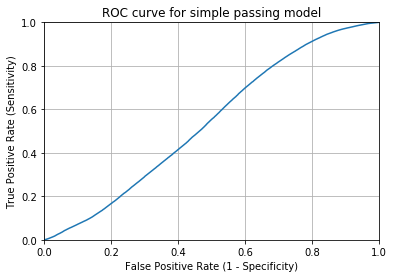

In [12]:
y_pred_prob = logreg.predict_proba(X_train)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for simple passing model')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

# 2.2 Random Forest 

Now let's try a random forest on our simple model to see how different it would be from the logistic regression.

In [13]:
# instantiate a logistic regression model
clf = RandomForestClassifier(n_jobs=2, random_state=0)

# use 10-fold cv to evaluate the performance
scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
print(scores)
print(scores.mean())

[0.82204389 0.82295668 0.82189176 0.82383144 0.82185373 0.82131447
 0.82249353 0.82314012 0.82336832 0.8225696 ]
0.822546354109645


In [14]:
# fit the data and make predictions
clf.fit(X_train, y_train)
y_pred_class = clf.predict(X_train)

# confusion matrix
print(metrics.confusion_matrix(y_train, y_pred_class))

[[  4171  41866]
 [  2414 214474]]


In [15]:
# other metrics
print("Accuracy:", metrics.accuracy_score(y_train, y_pred_class))
print("Recall:", metrics.recall_score(y_train, y_pred_class))
print("Precision:", metrics.precision_score(y_train, y_pred_class))

Accuracy: 0.8315869544546924
Recall: 0.9888698314337354
Precision: 0.8366778497308263


It's not just predicting accurate passes anymore. But it's clear we need to consider more features for our model.

# 3. Improved Model With More Features

In [16]:
xp_model = pd.DataFrame()

xp_model['label'] = df_pass['tags'].astype('str').str.contains('1801').astype(int) 
xp_model['x1'] = df_pass['positions'].str[0].str['x']
xp_model['y1'] = df_pass['positions'].str[0].str['y']
xp_model['x2'] = df_pass['positions'].str[1].str['x']
xp_model['y2'] = df_pass['positions'].str[1].str['y']
xp_model['pass_type'] = df_pass['subEventName']

In [17]:
# make sure there aren't any missing values
xp_model.isna().sum()

label        0
x1           0
y1           0
x2           0
y2           0
pass_type    0
dtype: int64

In [18]:
features_list = ['x1', 'y1', 'x2', 'y2', 'pass_type']
X = xp_model[features_list]
y = xp_model['label']

In [19]:
print(xp_model.shape)
print(X.shape)
print(y.shape)

(328657, 6)
(328657, 5)
(328657,)


In [20]:
# split the data into a training and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# Encode categorical variable
ohe = OneHotEncoder(sparse=False)
column_trans = make_column_transformer(
    (OneHotEncoder(), ['pass_type']),
    remainder='passthrough')
column_trans.fit_transform(X_train)

array([[ 0.,  0.,  0., ..., 18., 41., 36.],
       [ 0.,  0.,  0., ..., 17., 21.,  7.],
       [ 0.,  0.,  0., ..., 39., 40., 44.],
       ...,
       [ 0.,  0.,  0., ..., 70., 47., 90.],
       [ 0.,  0.,  0., ..., 31., 49., 53.],
       [ 0.,  0.,  0., ..., 43., 47., 66.]])

# 3.1 Improved Logistic Regression vs Random Forest

In [22]:
# instantiate the logistic regression model
logreg = LogisticRegression(solver='lbfgs', max_iter=2000)
pipe = make_pipeline(column_trans, logreg)

In [23]:
# cross validate the model
cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy').mean()

0.8408937910050394

Better than the simple model. Now let's look at the accuracy of the Random Forest after adding more features.

In [24]:
# now for the Random Forest
clf = RandomForestClassifier(n_jobs=2, random_state=0)
pipe = make_pipeline(column_trans, clf)

# use 5-fold cv to evaluate the performance
cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy').mean()

0.8595378910335647

So the Random Forest gives better accuracy. Next, we could do Randomised Grid Search to pick the optimum hyperparameters for the model.

# 4. Evaluate The Final Model On Out Of Sample Data

In [25]:
# fit the data and make predictions
pipe.fit(X_train, y_train)
y_pred_class = pipe.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred_class))
print("Recall:", metrics.recall_score(y_test, y_pred_class))
print("Precision:", metrics.precision_score(y_test, y_pred_class))
print("AUC:", metrics.roc_auc_score(y_test, y_pred_prob))

Accuracy: 0.858896732185237
Recall: 0.9487608471834094
Precision: 0.8883170089339507


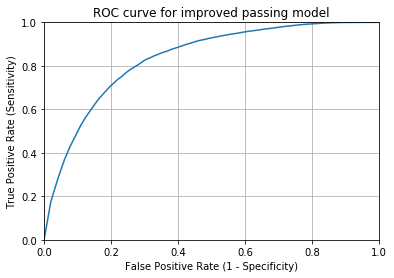

In [28]:
y_pred_prob = pipe.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for improved passing model')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [27]:
# get the AUC value
print("AUC:", metrics.roc_auc_score(y_test, y_pred_prob))

AUC: 0.8346523484688717
